# Scene Classification
## 1. Preprocess PickleFile
- Import pkg
- Extract zip file
- Preview "scene_classes.csv"
- Preview "scene_{0}_annotations_20170904.json"
- Test the image and pickle function
- Split data into serval pickle file

This part need jupyter notebook start with "jupyter notebook --NotebookApp.iopub_data_rate_limit=1000000000" (https://github.com/jupyter/notebook/issues/2287)

Reference:
- https://challenger.ai/competitions
- https://github.com/jupyter/notebook/issues/2287

### Import pkg

In [5]:
import numpy as np
import pandas as pd
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [6]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [7]:
# import zipfile
import os
import zipfile
import math
from time import time
from IPython.display import display
import pdb
import json
from PIL import Image
import glob
import pickle

### Extract zip file

In [8]:
input_path = './input'
datasetName = 'validation'
date = '20170908'

zip_path = input_path + '/ai_challenger_scene_{0}_{1}.zip'.format(datasetName, date)
extract_path = input_path + '/ai_challenger_scene_{0}_{1}'.format(datasetName, date)
image_path = extract_path + '/scene_{0}_images_{1}'.format(datasetName, date)
scene_classes_path = extract_path + '/scene_classes.csv'
scene_annotations_path = extract_path + '/scene_{0}_annotations_{1}.json'.format(datasetName, date)

print(input_path)
print(zip_path)
print(extract_path)
print(image_path)
print(scene_classes_path)
print(scene_annotations_path)

./input
./input/ai_challenger_scene_validation_20170908.zip
./input/ai_challenger_scene_validation_20170908
./input/ai_challenger_scene_validation_20170908/scene_validation_images_20170908
./input/ai_challenger_scene_validation_20170908/scene_classes.csv
./input/ai_challenger_scene_validation_20170908/scene_validation_annotations_20170908.json


In [9]:
if not os.path.isdir(extract_path):
    with zipfile.ZipFile(zip_path) as file:
        for name in file.namelist():
            file.extract(name, input_path)

### Preview "scene_classes.csv"

In [10]:
scene_classes = pd.read_csv(scene_classes_path, header=None)
display(scene_classes.head())

,0,1,2
0,0,航站楼,airport_terminal
1,1,停机坪,landing_field
2,2,机舱,airplane_cabin
3,3,游乐场,amusement_park
4,4,冰场,skating_rink


In [11]:
def get_scene_name(lable_number, scene_classes_path):
    scene_classes = pd.read_csv(scene_classes_path, header=None)
    return scene_classes.loc[lable_number, 2]
print(get_scene_name(0, scene_classes_path))

airport_terminal


### Preview "scene_{0}_annotations_20170904.json"

**This part need jupyter notebook start with "jupyter notebook --NotebookApp.iopub_data_rate_limit=1000000000"**
https://github.com/jupyter/notebook/issues/2287

In [12]:
with open(scene_annotations_path, 'r', encoding='utf-8') as file:
    content = ''
    for line in file:
        content = content + line
scene_annotations = json.loads(content)

In [13]:
#We get a list
print('scene_{0}_annotations.type: %{1}'.format(datasetName, type(scene_annotations)))
print('scene_{0}_annotations.shape: %{1}'.format(datasetName, len(scene_annotations)))
order = 0
print(scene_annotations[order])
print('label_id[{0}]:\t{1}'.format(order, scene_annotations[order]['label_id']))
print('image_id[{0}]:\t{1}'.format(order, scene_annotations[order]['image_id']))
print(type(scene_annotations[order]['label_id']))

scene_validation_annotations.type: %<class 'list'>
scene_validation_annotations.shape: %7120
{'label_id': '18', 'image_id': '0c58107693263d32551209512d858246e925fe29.jpg', 'image_url': 'http://m4.biz.itc.cn/pic/new/n/31/90/Img7919031_n.jpg'}
label_id[0]:	18
image_id[0]:	0c58107693263d32551209512d858246e925fe29.jpg
<class 'str'>


### Test the image and pickle function

Data save into pickle file:
[ 18.  13.]
(2, 224, 224, 3)
Load data from pickle file:
./input/pickle_validation/y_data_sample.p
./input/pickle_validation/x_data_sample.p
[ 18.  13.]
(2, 224, 224, 3)


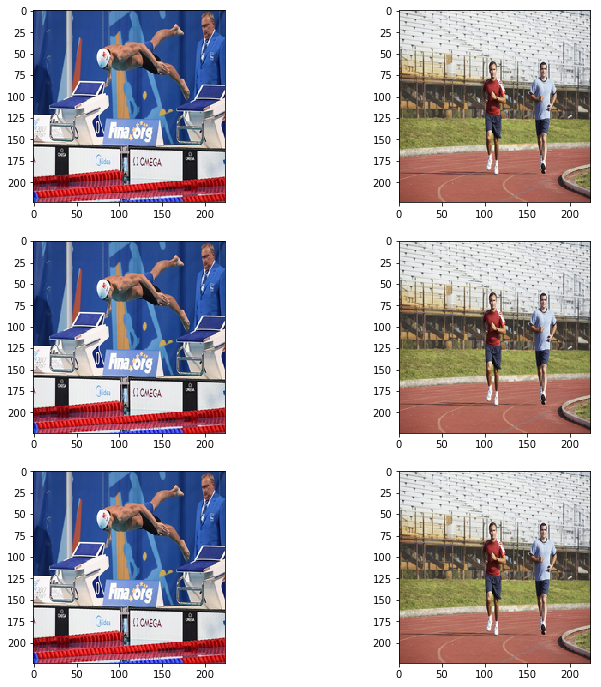

In [14]:
# length = len(scene_annotations)
length = 2
box = (224, 224)
x_shape = [length, box[0], box[1], 3]
x_data = np.zeros(x_shape)
y_data = np.zeros(length)

fig, ax = plt.subplots(3, length, figsize=(12, 12))

for i in range(length):
    y_data[i] = scene_annotations[i]['label_id']
    path = image_path + '/' + scene_annotations[i]['image_id']
    img = Image.open(path)
    img1 = img.resize(box, Image.ANTIALIAS) # resizes image in-place
    imgData = np.asarray(img1)
    ax[0][i].imshow(imgData)
    imgData = imgData.astype("float32")
    imgData = imgData/255.0
    ax[1][i].imshow(imgData)
    x_data[i] = imgData
    ax[2][i].imshow(x_data[i])

print('Data save into pickle file:')
print(y_data)
print(x_data.shape)
# print(x_data[0])

pickleFolder = 'pickle_{0}'.format(datasetName)
pickle_path = input_path + '/' + pickleFolder
if not os.path.isdir(pickle_path):
    os.mkdir(pickle_path)
    
x_data_path = pickle_path + '/x_data_sample.p'
y_data_path = pickle_path + '/y_data_sample.p'

pickle.dump(x_data, open(x_data_path, 'wb'))
pickle.dump(y_data, open(y_data_path, 'wb'))

x_data = pickle.load(open(x_data_path, mode='rb'))
y_data = pickle.load(open(y_data_path, mode='rb'))
print('Load data from pickle file:')
print(y_data_path)
print(x_data_path)
print(y_data)
print(x_data.shape)
del x_data
del y_data

### Split data into serval pickle file

In [15]:
def convert_and_save_data(partNum, partStart, partEnd):
    partLen = partEnd - partStart
    x_shape = [partLen, box[0], box[1], 3]
    x_data = np.zeros(x_shape)
    y_data = np.zeros(partLen)

    # fig, ax = plt.subplots(3, length, figsize=(12, 12))
    
    for i in range(partStart, partEnd):
        iPart = i-partStart
        y_data[iPart] = scene_annotations[i]['label_id']
        path = image_path + '/' + scene_annotations[i]['image_id']
        img = Image.open(path)
        img1 = img.resize(box, Image.ANTIALIAS) # resizes image in-place
        imgData = np.asarray(img1)
    #     ax[0][i].imshow(imgData)
        imgData = imgData.astype("float32")
        imgData = imgData/255.0
    #     ax[1][i].imshow(imgData)
        x_data[iPart] = imgData
    #     ax[2][i].imshow(x_data[i])

    print('Data save into pickle file:')
    print(y_data.shape)
    print(x_data.shape)
    # print(x_data[0])
    
    pickleFolder = 'pickle_{0}'.format(datasetName)
    pickle_path = input_path + '/' + pickleFolder

    if not os.path.isdir(pickle_path):
        os.mkdir(pickle_path)
    
    x_data_path = pickle_path + '/x_data' + str(partNum) + '.p'
    y_data_path = pickle_path + '/y_data' + str(partNum) + '.p'

    pickle.dump(x_data, open(x_data_path, 'wb'))
    pickle.dump(y_data, open(y_data_path, 'wb'))

    x_data = pickle.load(open(x_data_path, mode='rb'))
    y_data = pickle.load(open(y_data_path, mode='rb'))
    print('Load data from pickle file:')
    print(y_data.shape)
    print(x_data.shape)

In [17]:
%%time
## dump file size can not larger than 4GB
length = len(scene_annotations)
length = 4096
partLen = 1024
partAmount = math.ceil(length/partLen)
print('data length:\t{0}'.format(length))
print('partSize:\t{0}'.format(partLen))
print('partAmount:\t{0}'.format(partAmount))

box = (200, 200)
print('image box:\t{0}x{1}'.format(box[0], box[1]))

for i in range(partAmount):
    remainder = length - i*partLen
    if remainder < partLen:
        thisPartLen = remainder
    else:
        thisPartLen = partLen

    partStart = partLen*i
    partEnd   = partLen*(i+1)
    if partEnd > length:
        partEnd = length
    print('Part {0}:\t\t{1}\t{2}'.format(i, partStart, partEnd))
    convert_and_save_data(i, partStart, partEnd)

data length:	4096
partSize:	1024
partAmount:	4
image box:	200x200
Part 0:		0	1024
Data save into pickle file:
(1024,)
(1024, 200, 200, 3)
Load data from pickle file:
(1024,)
(1024, 200, 200, 3)
Part 1:		1024	2048
Data save into pickle file:
(1024,)
(1024, 200, 200, 3)
Load data from pickle file:
(1024,)
(1024, 200, 200, 3)
Part 2:		2048	3072
Data save into pickle file:
(1024,)
(1024, 200, 200, 3)
Load data from pickle file:
(1024,)
(1024, 200, 200, 3)
Part 3:		3072	4096
Data save into pickle file:
(1024,)
(1024, 200, 200, 3)
Load data from pickle file:
(1024,)
(1024, 200, 200, 3)
Wall time: 1min 27s


### Reload and preview

EOFError: Ran out of input

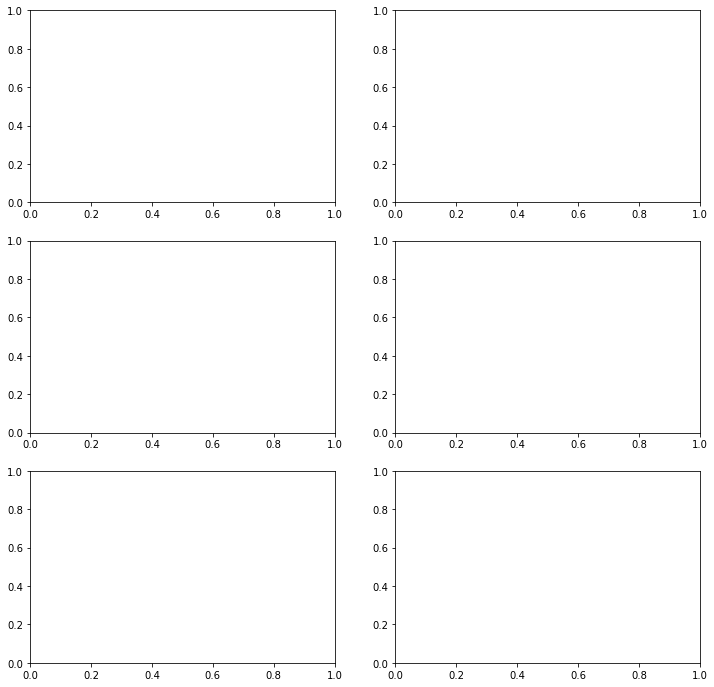

In [13]:
pickleLen = 2
samplelen = 3
fig, ax = plt.subplots(samplelen, pickleLen, figsize=(12, 12))
pickleFolder = 'pickle_{0}'.format(datasetName)
pickle_path = input_path + '/' + pickleFolder
for i in range(pickleLen):
    x_data_path = pickle_path + '/x_data{0}.p'.format(i)
    y_data_path = pickle_path + '/y_data{0}.p'.format(i)
    x_data = pickle.load(open(x_data_path, mode='rb'))
    y_data = pickle.load(open(y_data_path, mode='rb'))
    for j in range(samplelen):
        ax[j][i].imshow(x_data[j])
        ax[j][i].set_title(get_scene_name(y_data[j], scene_classes_path))

In [ ]:
print('Done!')